In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import torch
import torchvision
import tarfile
import copy
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
project_name='Resnet_9'

**Loading the Dataset**

In [5]:
%cd ../input/facial-expression-dataset-image-folders-fer2013
%ls

/kaggle/input/facial-expression-dataset-image-folders-fer2013
data/


Data divided into train(80%), test(10%), and validation(10%) sets in ImageFolder format.
Labels are:
0 - Angry
1 - Disgust
2 - Fear
3 - Happy
4 - Sad
5 - Surprise
6 - Neutral

In [6]:
classLabels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

data_dir = 'data'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/val")
classes_test = os.listdir(data_dir + "/test")

classesTrain = [classLabels[int(i)] for i in classes_train]
classesTest = [classLabels[int(i)] for i in classes_test]
classesVal = [classLabels[int(i)] for i in classes_valid]

print(f'Train Classes - {classesTrain}')
print(f'Validation Classes - {classesVal}')
print(f'Test Classes - {classesTest}')

['val', 'test', 'train']
Train Classes - ['Fear', 'Surprise', 'Angry', 'Happy', 'Disgust', 'Sad', 'Neutral']
Validation Classes - ['Fear', 'Surprise', 'Angry', 'Happy', 'Disgust', 'Sad', 'Neutral']
Test Classes - ['Fear', 'Surprise', 'Angry', 'Happy', 'Disgust', 'Sad', 'Neutral']


In [7]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [8]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/val', valid_tfms)
test_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [9]:
batch_size = 64

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [12]:
def datasetSummary(batchS, labelsS):
    labelsC = {}
    for images, labels in batchS:
        for labs in labels:
            if labs.item() not in labelsC:
                labelsC[labs.item()] = 1
            else:
                labelsC[labs.item()] += 1
    for labels in labelsC.keys():
        print("Count of label {0} is {1}".format(labelsS[labels], labelsC[labels]))

**Training Dataset Summary**

In [13]:
datasetSummary(train_dl, classLabels)

Count of label Fear is 4097
Count of label Happy is 7215
Count of label Angry is 3995
Count of label Neutral is 4965
Count of label Surprise is 3171
Count of label Sad is 4830
Count of label Disgust is 436


**Validation Dataset Summary**

In [14]:
datasetSummary(valid_dl, classLabels)

Count of label Angry is 467
Count of label Disgust is 56
Count of label Fear is 496
Count of label Happy is 895
Count of label Sad is 653
Count of label Surprise is 415
Count of label Neutral is 607


**Testing Dataset Summary**

In [15]:
datasetSummary(test_dl, classLabels)

Count of label Angry is 491
Count of label Disgust is 55
Count of label Fear is 528
Count of label Happy is 879
Count of label Sad is 594
Count of label Surprise is 416
Count of label Neutral is 626


torch.Size([1, 48, 48])


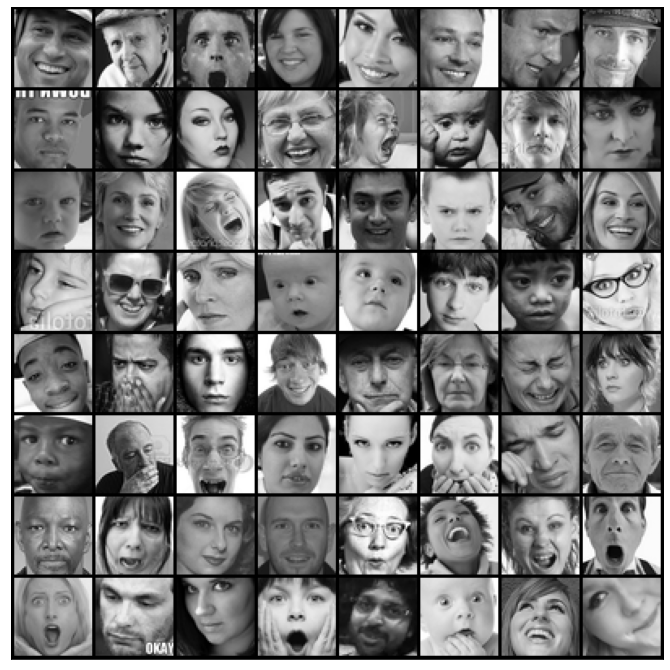

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)


In [22]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    min_loss=float('inf')

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        resultTemp = evaluate(model, train_loader)
        result['train_loss'] = resultTemp['val_loss']
        result['train_acc'] = resultTemp['val_acc']
        model.epoch_end(epoch, result)
        history.append(result)
        if(min_loss > result['val_loss']):
            bestModel = copy.deepcopy(model)
            min_loss = result['val_loss']
            print("Saving Best Model with loss: ", result['val_loss'])
    return history, bestModel

In [24]:
histor = [evaluate(model, valid_dl)]

In [25]:
bestModel = None
epochs = 50
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
his , bestModel= fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 1.8398, val_loss: 1.8382, val_acc: 0.2475
Saving Best Model with loss:  1.8381896018981934
Epoch [1], last_lr: 0.00008, train_loss: 1.8263, val_loss: 1.8258, val_acc: 0.2469
Saving Best Model with loss:  1.8258488178253174
Epoch [2], last_lr: 0.00013, train_loss: 1.8708, val_loss: 1.8702, val_acc: 0.1985
Epoch [3], last_lr: 0.00020, train_loss: 1.7675, val_loss: 1.7665, val_acc: 0.3169
Saving Best Model with loss:  1.7664729356765747
Epoch [4], last_lr: 0.00028, train_loss: 1.7459, val_loss: 1.7429, val_acc: 0.3265
Saving Best Model with loss:  1.7428971529006958
Epoch [5], last_lr: 0.00037, train_loss: 1.6845, val_loss: 1.6804, val_acc: 0.3302
Saving Best Model with loss:  1.6804076433181763
Epoch [6], last_lr: 0.00047, train_loss: 1.6083, val_loss: 1.6120, val_acc: 0.3492
Saving Best Model with loss:  1.6120105981826782
Epoch [7], last_lr: 0.00057, train_loss: 1.4707, val_loss: 1.4775, val_acc: 0.4549
Saving Best Model with loss:  1.4775208234

NameError: name 'history' is not defined

In [27]:
histor += his

In [28]:
len(histor)

51

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [30]:
def plot_loss(num_epochs,history):
    val_accuracy = [x['val_loss'] for x in history if 'train_acc' in x.keys()]
    train_accuracy = [x['train_loss'] for x in history if 'train_acc' in x.keys()]
    X = range(num_epochs)
    y = train_accuracy
    z = val_accuracy
    
    plt.plot(X,y,color='blue')
    plt.plot(X,z,color='red')
    plt.legend(['Train Loss','Validation Loss'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")

In [31]:
def plot_acc(num_epochs,history):
    val_accuracy = [x['val_acc']*100 for x in history if 'train_acc' in x.keys()]
    train_accuracy = [x['train_acc']*100 for x in history if 'train_acc' in x.keys()]
    X = range(num_epochs)
    y = train_accuracy
    z = val_accuracy
    
    plt.plot(X,y,color='blue')
    plt.plot(X,z,color='red')
    plt.legend(['Train Accuracy','Validation Accuracy'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracy")

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

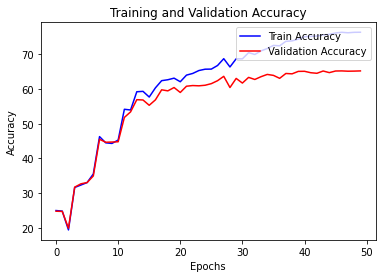

In [33]:
plot_acc(50, histor)

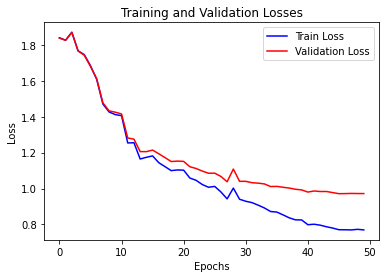

In [34]:
plot_loss(50, histor)

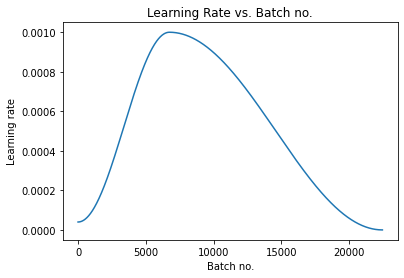

In [35]:
plot_lrs(histor)

In [ ]:
%cd ../../working
torch.save(bestModel.state_dict(), 'resNet9.pth')
%ls

In [36]:
@torch.no_grad()
def validation_step(model, val_loader):
    model.eval()
    pred = []
    preDefined = []
    count = 0
    for batch in val_loader:
        images, labels = batch
        count += len(labels)
        output = model(images)
        
        _, preds = torch.max(output, dim=1)    

        pred += preds
        preDefined += labels

        
    preds = []
    for pre in pred:
        preds.append(pre.item())
    print(preds[0:10])
    predefined = []
    for pre in preDefined:
        predefined.append(pre.item())
    return preds, predefined
    

In [37]:
def buildConfusionMatrix(preDefined, preds, class_names):
    #arr = confusion_matrix(y_gt.view(-1).detach().cpu().numpy(), y_pred.view(-1).detach().cpu().numpy())
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    #df_cm = pd.DataFrame(arr, class_names, class_names)
    cm = confusion_matrix(preDefined, preds)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize = (9,6))
    #annot=True, fmt='g', ax=ax
    #sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    print("\n")
    sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='BuGn')

    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()
    print('\n')

In [ ]:
%cd ../input/facial-expression-dataset-image-folders-fer2013
%ls

In [38]:
predTrain, predefinedTrain = validation_step(bestModel, train_dl)
predTest, predefinedTest = validation_step(bestModel, test_dl)
predVal, predefinedVal = validation_step(bestModel, valid_dl)

[4, 4, 0, 4, 5, 5, 5, 3, 0, 6]
[4, 4, 0, 6, 5, 6, 5, 3, 0, 6]
28709
28709
28709
[0, 0, 2, 4, 0, 2, 4, 3, 0, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3589
3589
3589
[4, 4, 2, 0, 5, 6, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3589
3589
3589


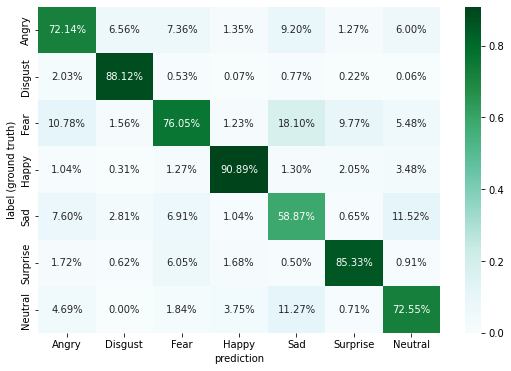

In [39]:
buildConfusionMatrix(predefinedTrain, predTrain, classLabels)

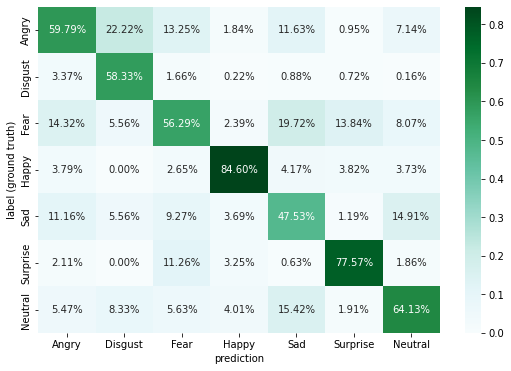

In [40]:
buildConfusionMatrix(predefinedTest, predTest, classLabels)

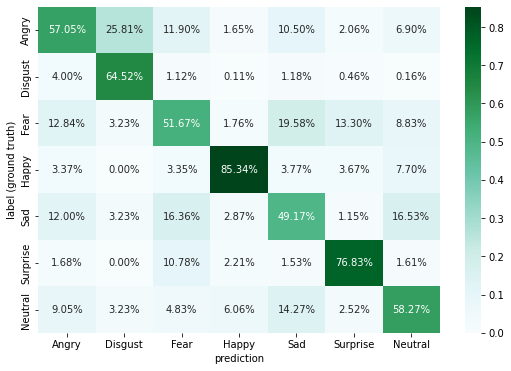

In [41]:
buildConfusionMatrix(predefinedVal, predVal, classLabels)

In [42]:
model_1 = to_device(ResNet(1, len(classes_train)), device)


In [ ]:

his = []
his , bestModel_1= fit_one_cycle(epochs, max_lr, model_1, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay)

In [ ]:
print(len(his))